In [1]:
%matplotlib inline
import pickle
import pandas as pd
import seaborn as sns
import biothings_client
from pathlib import Path
from itertools import chain
import data_tools.graphs as gt
import matplotlib.pyplot as plt
from data_tools.wiki import get_curi_xrefs
from data_tools.files import load_api_results
from data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty
from data_tools.df_processing import expand_col_on_char, combine_group_cols_on_char, char_combine_frame

# Local procesing scripts
from tools import biothings_processing as bp
from tools import hetnet_file_processing as hfp
from tools.stitcher import download_stitcher, organize_data

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Get Output Directory ready
this_file = '07a_NCATS_Inxight_Drugs_DB_and_DC'
out_dir = Path('../2_pipeline/').resolve()
out_dir = out_dir.joinpath(this_file).joinpath('out')

if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
d = load_api_results(out_dir.joinpath('stitcher_dump_{}.pkl'), False, download_stitcher)

In [4]:
d[9102]

{'USapproved': 'null',
 'kind': 'ncats.stitcher.Stitch',
 'rank': 2,
 'initiallyMarketedUS': 'null',
 'source': 'd58d0d292',
 'initiallyMarketed': 'null',
 'id': 872146,
 'datasource': {'id': 797502, 'key': 'd58d0d292', 'name': 'stitch_v1'},
 'labels': ['G-SRS, April 2019', 'SGROUP', 'stitch_v1'],
 'sgroup': {'hash': 'd58d0d292da3fe1497',
  'size': 2,
  'parent': 170200,
  'members': [{'source': 'G-SRS, April 2019',
    'node': 159555,
    'payloadNode': 159556,
    'id': 'U02VE8MHVB',
    'name': 'TOLPERISONE HYDROCHLORIDE, (S)-',
    'stitches': {'H_LyChI_L3': ['R94UADP5HUU-N'],
     'H_LyChI_L4': 'R9UNHYDJ6XXB-N'}},
   {'source': 'G-SRS, April 2019',
    'node': 170200,
    'payloadNode': 170201,
    'id': '88IQ3US5N5',
    'name': 'TOLPERISONE, (S)-',
    'stitches': {'H_LyChI_L3': ['R94UADP5HUU-N'],
     'H_LyChI_L4': 'R9UNHYDJ6XXB-N'}}],
  'properties': {'CAS': [{'node': 170201, 'value': '298700-23-9'},
    {'node': 159556, 'value': '1280219-64-8'}],
   'MOLFILE': [{'node': 17020

In [5]:
data = organize_data(d)

100%|██████████| 102383/102383 [00:12<00:00, 8326.35it/s] 


In [6]:
data[9102]

{'nodes': [170201, 159556],
 'xrefs': {'CAS': {'1280219-64-8', '298700-23-9'},
  'PUBCHEM': {688589, 56959888},
  'SMILES': {'C[C@@H](CN1CCCCC1)C(=O)C2=CC=C(C)C=C2',
   'Cl.C[C@@H](CN1CCCCC1)C(=O)C2=CC=C(C)C=C2'},
  'UNII': {'88IQ3US5N5', 'U02VE8MHVB'},
  'DRUGBANK': set(),
  'CHEMBL.COMPOUND': set()},
 'conditions': {'meshids': [],
  'phases': [],
  'modalities': [],
  'doids': [],
  'do_precision': [],
  'mesh_precision': [],
  'names': [],
  'dates': []},
 'targets': {'ids': [], 'sources': [], 'pharmas': [], 'names': []}}

## First make sense of all the compounds within the ncats inxight drugs records

The problem is that each record has several 'nodes' in it.  Sometimes these nodes represent different molecules, like different salt forms, with differnt UNIIs. This may result in a given node contains different x-refs for the same item (e.g. UNII, Drugbank, and name all correspond to the same compound on the same node). However, other times, there are different nodes within a record with the same compound. For example one node may have the UNII while the other may have the Drugbank Identifier, an yet another may have the name.  The majority of cases, though have many nodes representing many compounds, e.g. 8 nodes, for 2 compounds, with different identifiers spread across the nodes.

To remidy this we will extract x-refs of only once source for a given record, in priorty order of the global variable `CHEM_XREF_KEY_ORDER` (see `records_to_chem_nodes` fucntion in `./tools/hetnet_file_proccessing.py` ). We will then use mychem.info to get the correct x-refs and name for that item.  If there are more than one uniuqe identifier in a a record (e.g. 2 salt forms of the same basic structure), all treats and targets edges will be assigned to every identifier within that record during a future step.

In [7]:
chem_nodes = hfp.records_to_chem_nodes(data)
chem_nodes.head(2)

,id,name,source,label
0,SP86R356CC,GET,UNII,Compound
1,C50C4V19SU,GET,UNII,Compound


In [8]:
len(chem_nodes)

119832

In [9]:
chem_nodes['id'].nunique()

116721

In [10]:
chem_nodes['source'].value_counts()

UNII               105020
SMILES               4544
CAS                  4235
DRUGBANK             4139
CHEMBL.COMPOUND      1147
CompoundCID           474
Iupac                 273
Name: source, dtype: int64

In [11]:
mc = biothings_client.get_client('chem')

my_chem_ids = ['UNII', 'DRUGBANK', 'CHEMBL.COMPOUND', 'CompoundCID', 'InChIKey']
to_query = chem_nodes.query('source == @my_chem_ids')['id'].unique()
len(to_query)

110754

In [12]:
mychem_res = load_api_results(out_dir.joinpath('mychem_dump_{}.pkl'), re_scrape=False, 
                              scrape_function=bp.download_mychem_ids, chem_ids=to_query)

In [13]:
chem_node_df = bp.process_chemicals_in_mychem_results(mychem_res)
len(chem_node_df)

110754

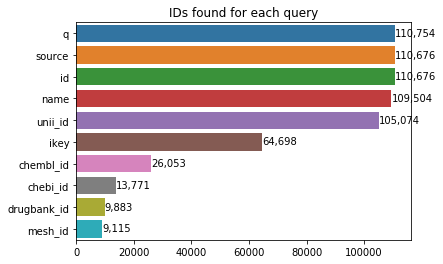

In [14]:
count_plot_h(chem_node_df.count())
plt.title("IDs found for each query");

In [15]:
chem_node_df.head(2)

,q,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,name,id,source
0,SP86R356CC,FZERHIULMFGESH-UHFFFAOYSA-N,CHEBI:28884,CHEMBL269644,NaN,SP86R356CC,MESH:C508827,Acetanilide,FZERHIULMFGESH-UHFFFAOYSA-N,ikey
1,C50C4V19SU,SWMPGCCDXNLPED-NSCUHMNNSA-N,NaN,NaN,NaN,C50C4V19SU,MESH:C005910,Acetylfuratrizine,SWMPGCCDXNLPED-NSCUHMNNSA-N,ikey


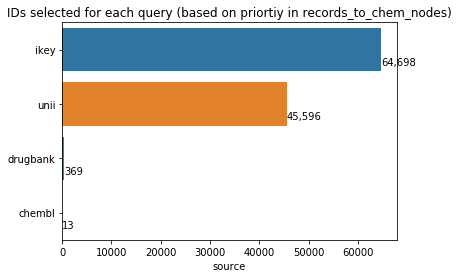

In [16]:
count_plot_h(chem_node_df['source'])
plt.title('IDs selected for each query (based on priortiy in records_to_chem_nodes)');

In [17]:
len(chem_node_df)

110754

In [18]:
chem_node_df['id'].nunique()

110526

In [19]:
len(chem_node_df.dropna(subset=['id']))

110676

In [20]:
# Get a map from inxight_id to the new mychem ID
inxight_to_chem_id = chem_node_df[['q', 'id']].copy()

# Get rid of drugs that were not found...
chem_node_df = chem_node_df.dropna(subset=['id']).drop_duplicates(subset=['id']).drop('q', axis=1)
len(chem_node_df)

110526

In [21]:
def make_mg_uniprot_map(mg_res):                                                                                        
    # Some one to many found, so we will de-duplicate                                                                   
    qs = [x['query'] for x in mg_res['out']]
    rs = [x.get('entrezgene', float('nan')) for x in mg_res['out']]
                                                                                                                        
    return pd.DataFrame({'uniprot_id': qs, 'entrez_id': rs})

In [22]:
'test_teas_new'[:-4]

'test_teas'

In [23]:
def map_via_merge(orig_df, map_df, orig_id_col, map_id_col, new_id_col):
    params = {'right': map_df, 'how': 'left'}
    
    changed_final = False
    
    # its a problem if the new_id_col and orig_id_col have the same name...
    if orig_id_col == new_id_col:
        map_df = map_df.rename(columns={orig_id_col: orig_id_col+'_orig'})
        orig_id_col = orig_id_col + '_orig'

    # also issues if the new column already exists in here
    elif new_id_col in orig_df.columns:
        final_id_col = new_id_col
        new_id_col = new_id_col + '_new'
        map_df = map_df.rename(columns={final_id_col: new_id_col})
        changed_final = True
        
    # Choose the proper merge command
    if orig_id_col == map_id_col:
        params['on'] = orig_id_col
    else:
        params['left_on'] = orig_id_col
        params['right_on'] = map_id_col
        
    out = (orig_df.merge(**params))
    
    # Only need one instance of the merge column
    if orig_id_col != map_id_col:
        out = out.drop([map_id_col], axis=1)
        
    # Fill missing values with new mappings, but keep if the merge column alread exists
    if changed_final:
        print('Warning: out column already exists. Only filling missing values')
        out[final_id_col] = out[final_id_col].fillna(out[new_id_col])
        out = out.drop([new_id_col], axis=1)
        
    return out

In [24]:
def map_inxight_chem_ids(map_to, to_column, inxight_to_chem_id, out_id_rename):
    
    out = map_via_merge(map_to, inxight_to_chem_id, to_column, 'q', 'id')
    out = out.drop([to_column], axis=1).rename(columns={'id': out_id_rename})
    
    return out

In [25]:
def map_uniprot_to_entrez(map_to, to_column, uniprot_map, out_id_rename):
    
    out = map_via_merge(map_to, uniprot_map, to_column, 'uniprot_id', 'entrez_id')
    
    if out_id_rename in out.columns:
        print('Warning: out column already exists. Only filling missing values')
        out[out_id_rename] = out[out_id_rename].fillna(out['entrez_id'])
        out = out.drop(['entrez_id'], axis=1)
    else:
        out = out.rename(columns={'entrez_id': out_id_rename})
    
    return out

In [26]:
chem_node_df['label'] = "Compound"
chem_node_df = gt.order_cols(chem_node_df)

In [27]:
chem_node_df.head(2)

,id,name,label,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,source
0,FZERHIULMFGESH-UHFFFAOYSA-N,Acetanilide,Compound,FZERHIULMFGESH-UHFFFAOYSA-N,CHEBI:28884,CHEMBL269644,NaN,SP86R356CC,MESH:C508827,ikey
1,SWMPGCCDXNLPED-NSCUHMNNSA-N,Acetylfuratrizine,Compound,SWMPGCCDXNLPED-NSCUHMNNSA-N,NaN,NaN,NaN,C50C4V19SU,MESH:C005910,ikey


## Sort out the targets

Targets are a mess, there are many different identifiers for targets, however one of the primary identifiers is the ChEMBL.Target which are not widely used by other data-sources and do not x-ref well to other databases. Ideally we want Entrez Gene IDs for any gene targets. We can get there thorugh either ENSEBL gene ids, or UniProt identifiers. However, getting xrefs from ChEMBL.Targets to either of these will require use of the ChEMBL API.

There are also many targets that do not qualify as protein or gene targets, so they will not be mappable to Entrez. This may include Organisms, Cell Types, Nuclaic Acids, or Small Molecules. We will keep the ChEMBL identifier in this case, but also keep all x-refs in case we need to perform future identifier resolution.

In [28]:
targets = hfp.records_to_target_nodes(data)
len(targets)

5904

In [29]:
targets.head(2)

,id,name,label,id_source
0,GO:0032611,interleukin-1 beta production,Target,GO Cell Process
1,CHEMBL2111463,GABA-B receptor,Target,ChEMBL


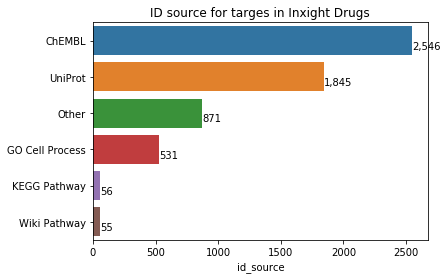

In [30]:
count_plot_h(targets['id_source'])
plt.title('ID source for targes in Inxight Drugs');

In [31]:
chembl_targets = targets.query('id_source == "ChEMBL"')['id'].unique()
len(chembl_targets)

2546

In [32]:
chembl_api_res = load_api_results(out_dir.joinpath('chembl_targets_dump_{}.pkl'), False, 
                              hfp.download_chembl_targets, target_ids=chembl_targets)

In [33]:
chembl_tgt_info = hfp.process_chembl_targets_api(chembl_api_res)
len(chembl_tgt_info)

235079

In [34]:
chembl_tgt_info.head(2)

,organism,target_chembl_id,tax_id,target_type,pref_name,component_type,component_id,xref_name,xref_src_db,xref_id
0,Candida albicans,CHEMBL2364680,5476,SINGLE PROTEIN,Thymidylate synthase,PROTEIN,7864,thymidylate synthase activity,GoFunction,GO:0004799
1,Candida albicans,CHEMBL2364680,5476,SINGLE PROTEIN,Thymidylate synthase,PROTEIN,7864,methyltransferase activity,GoFunction,GO:0008168


In [35]:
chembl_tgt_info.drop_duplicates(subset=['target_chembl_id'])['target_type'].value_counts()

SINGLE PROTEIN                  1907
PROTEIN FAMILY                   154
ORGANISM                         149
PROTEIN COMPLEX                  138
CELL-LINE                         87
PROTEIN COMPLEX GROUP             39
SELECTIVITY GROUP                 25
NUCLEIC-ACID                      12
SMALL MOLECULE                     8
METAL                              8
SUBCELLULAR                        4
PROTEIN-PROTEIN INTERACTION        4
PROTEIN NUCLEIC-ACID COMPLEX       4
UNKNOWN                            3
MACROMOLECULE                      2
CHIMERIC PROTEIN                   1
Name: target_type, dtype: int64

In [36]:
chembl_tgt_info['xref_src_db'].value_counts()

GoProcess              62309
PDBe                   39805
GoComponent            29767
GoFunction             29749
InterPro               21818
UniProt                15966
Reactome               15497
Pfam                    6760
IntAct                  2609
EnsemblGene             2574
ExpressionAtlas         2146
PharmGKB                2121
GuideToPHARMACOLOGY     1755
Pharos                  1175
CGD                      659
TIMBAL                    84
Name: xref_src_db, dtype: int64

In [37]:
chembl_tgt_info['component_type'].value_counts()

PROTEIN    234794
RNA            12
Name: component_type, dtype: int64

Most of these xrefs are actually annotations for the targets.  It may be worth extracting some of them to get target to annoation edges, but for the purpose of this (finding the target of a given drug), we only want the actual target.  Many of the annotations should already be within the network. For this reason we will stick to the following xrefs for initial xtraction:

- UniProt
- EnemblGene

Annotations can be grabbed from the following Sources:

- GO (BP, CC, MF)
- InterPro
- Reactome


In [38]:
anno_sources = ['GoProcess', 'GoComponent', 'GoFunction', 'InterPro', 'Reactome']
chembl_tgt_anno = chembl_tgt_info.query('xref_src_db in @anno_sources')

In [39]:
chembl_tgt_xrefs = hfp.select_chembl_target_xref(chembl_tgt_info)
len(chembl_tgt_xrefs)

3885

In [40]:
# Filter annotations to only those we have an xref for
xrefd_chembls = chembl_tgt_xrefs['target_chembl_id'].unique()
chembl_tgt_anno = chembl_tgt_anno.query('target_chembl_id in @xrefd_chembls')

In [41]:
# And see what we couldn't get an xref for
set(chembl_targets) - set(chembl_tgt_xrefs['target_chembl_id'].unique())

{'CHEMBL614639'}

looks like just one didn't get a result

In [42]:
found_ids = chembl_tgt_xrefs['target_chembl_id'].unique()
targets.query('id not in @found_ids and id_source == "ChEMBL"')

,id,name,label,id_source
2643,CHEMBL614639,Lipopolysaccharide,Target,ChEMBL


CHEMBL614639 returns no results... This may be the proper identifier for LPS?   
https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL3580508/

In [43]:
chembl_tgt_xrefs['target_chembl_id'].nunique()

2545

In [44]:
len(targets)

5904

In [45]:
targets.nunique()

id           5713
name         3643
label           1
id_source       6
dtype: int64

In [46]:
targets = pd.merge(targets, chembl_tgt_xrefs, left_on=['id'], right_on=['target_chembl_id'], how='left')
targets.head()

,id,name,label,id_source,organism,target_chembl_id,tax_id,target_type,pref_name,component_type,component_id,xref_name,xref_src_db,xref_id
0,GO:0032611,interleukin-1 beta production,Target,GO Cell Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,404,None,EnsemblGene,ENSG00000204681
2,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,3345,None,EnsemblGene,ENSG00000136928
3,Q04212,D-arabinose 1-dehydrogenase,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHEMBL1991,Inhibitor of nuclear factor kappa B kinase bet...,Target,ChEMBL,Homo sapiens,CHEMBL1991,9606,SINGLE PROTEIN,Inhibitor of nuclear factor kappa B kinase bet...,PROTEIN,321,None,EnsemblGene,ENSG00000104365


#### Use mygene.info to get the proper gene xrefs

We will now get the xrefs from esembel and uniprot to entrez with mygene.info

In [47]:
import biothings_client
mg = biothings_client.get_client('gene')

ensembel_xref = mg.getgenes(targets.query('xref_src_db == "EnsemblGene"')['xref_id'].unique(), fields=['entrezgene'])
ensembel_map = {g['query']: g.get('entrezgene', float('nan')) for g in ensembel_xref}

querying 1-1000...done.
querying 1001-1725...done.


In [48]:
prots = targets.query('xref_src_db == "UniProt"')['xref_id'].unique()
uniprot_xref = mg.querymany(prots, scopes='uniprot', fileds=['entrezgene'], size=50, returnall=True)

querying 1-1000...done.
querying 1001-1079...done.
Finished.
42 input query terms found dup hits:
	[('Q2FW31', 2), ('Q2FW19', 2), ('Q2FXZ7', 2), ('P48940', 2), ('Q2FW11', 2), ('Q2FZ60', 2), ('Q2FW14'
476 input query terms found no hit:
	['P07265', 'P03366', 'Q9EPV4', 'A9JQL9', 'Q75VQ4', 'P04757', 'O35769', 'O08952', 'P20420', 'P10481',


In [49]:
uniprot_map = make_mg_uniprot_map(uniprot_xref)

In [50]:
uniprot_map

,uniprot_id,entrez_id
0,Q01061,281970
1,P14100,281969
2,Q9WTR4,83511
3,P07265,NaN
4,P03366,NaN
...,...,...
1122,P04799,24297
1123,P35961,NaN
1124,Q05BR4,NaN
1125,Q8R431,29254


In [51]:
# Also some uniprot ids in inxighight without having to go through chembl
uniprot_targets = targets.query('id_source == "UniProt"')['id'].unique()
r = mg.querymany(uniprot_targets, scopes='uniprot', fields=['entrezgene'], size=50, returnall=True)

uniprot_map = pd.concat([make_mg_uniprot_map(r), uniprot_map], sort=False, ignore_index=True).drop_duplicates()

querying 1-1000...done.
querying 1001-1654...done.
Finished.
15 input query terms found dup hits:
	[('P35226', 2), ('P32324', 2), ('P31941', 2), ('P62593', 38), ('P36544', 2), ('P0A7S3', 2), ('P49674
290 input query terms found no hit:
	['Q9UQ99', 'Q14307', 'Q9UQP9', 'P16788', 'Q9GZX1', 'Q9UCB0', 'Q5VZI8', 'Q9GSR5', 'Q96DW4', 'Q86Z27',


In [52]:
# Map over these new identifiers
targets['new_id'] = targets['xref_id'].map(ensembel_map)

targets = map_uniprot_to_entrez(targets, 'xref_id', uniprot_map, 'new_id')
targets = map_uniprot_to_entrez(targets, 'id', uniprot_map, 'new_id')

entrez_idx = targets[~targets['new_id'].isnull()].index
other_idx = targets[targets['new_id'].isnull()].index
targets.loc[entrez_idx, 'source'] = 'entrez'
# Take xref first, then fill missing with the original id (Try to get rid of as many CHEMBL IDs as possible)
targets.loc[other_idx, 'new_id'] = targets.loc[other_idx, 'xref_id'].fillna(targets.loc[other_idx, 'id'])
targets.loc[other_idx, 'source'] = targets.loc[other_idx, 'xref_src_db'].fillna(targets.loc[other_idx, 'id_source'])

targets['source'].value_counts()

entrez             4545
UniProt            1008
Other               871
GO Cell Process     531
ChEMBL              274
KEGG Pathway         56
Wiki Pathway         55
EnsemblGene           3
Name: source, dtype: int64

In [53]:
curi_map = {'GO Cell Process': '', 'entrez': 'NCBIGene:', 'UniProt': 'UniProt:', 'ChEMBL': 'CHEMBL:', 
            'Wiki Pathway': 'WP:', 'KEGG Pathway': 'KEGG:', 'uniprot': 'UniProt:', 'other': ''}

targets['new_id'] = targets['source'].map(curi_map) + targets['new_id']
# keep track of the original ID for mapping edges, but add CURIs for Xref accounting
targets['curi_id'] = targets['id_source'].map(curi_map) + targets['id']
targets.head()

,id,name,label,id_source,organism,target_chembl_id,tax_id,target_type,pref_name,component_type,component_id,xref_name,xref_src_db,xref_id,new_id,source,curi_id
0,GO:0032611,interleukin-1 beta production,Target,GO Cell Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GO:0032611,GO Cell Process,GO:0032611
1,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,404,None,EnsemblGene,ENSG00000204681,NCBIGene:2550,entrez,CHEMBL:CHEMBL2111463
2,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,3345,None,EnsemblGene,ENSG00000136928,NCBIGene:9568,entrez,CHEMBL:CHEMBL2111463
3,Q04212,D-arabinose 1-dehydrogenase,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCBIGene:855057,entrez,UniProt:Q04212
4,CHEMBL1991,Inhibitor of nuclear factor kappa B kinase bet...,Target,ChEMBL,Homo sapiens,CHEMBL1991,9606,SINGLE PROTEIN,Inhibitor of nuclear factor kappa B kinase bet...,PROTEIN,321,None,EnsemblGene,ENSG00000104365,NCBIGene:3551,entrez,CHEMBL:CHEMBL1991


In [54]:
xref_curi_map = {'EnsemblGene': 'ENSG:', 'UniProt': 'UniProt:'}
targets['xref_id'] = targets['xref_src_db'].map(xref_curi_map) + targets['xref_id']

In [55]:
# keep track of xrefs
targets['xrefs'] = targets[['curi_id', 'xref_id']].T.apply(lambda r: '|'.join(sorted([x for x in r if type(x) == str])))

#### Sanity check the targets

In [56]:
targets.replace("", float('nan')).count()

id                  7154
name                6472
label               7343
id_source           7343
organism            3933
target_chembl_id    3933
tax_id              3933
target_type         3933
pref_name           3933
component_type      3660
component_id        3660
xref_name           3660
xref_src_db         3660
xref_id             3660
new_id              6469
source              7343
curi_id             6472
xrefs               6472
dtype: int64

There appear to be some targets that either were mising an identifier or a name when first extracted

In [57]:
targets[targets.replace("", float('nan'))['name'].isnull()].sample(10)

,id,name,label,id_source,organism,target_chembl_id,tax_id,target_type,pref_name,component_type,component_id,xref_name,xref_src_db,xref_id,new_id,source,curi_id,xrefs
2604,CHEMBL3885558: Cyclin-dependent kinases regula...,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
2075,hepatitis C virus non-structural protein 4B,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
5490,heteromeric CNGA1+CNGB1 channels,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
69,AP2 complex,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
286,calcium ion,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
4224,calcium,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
232,Soluble adenylyl cyclase,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
3205,smooth muscle,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
1401,CHEMBL1201244: ROCURONIUM,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,
3122,imidazoline I2 receptors,None,Target,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,


So the ones missing a name actually look like thye have an their name as an identifier.  This is problematic and will making reolving these entries time-consuming and difficult.

First let's check how many appear to be properly annotated

In [58]:
len(targets.replace("", float('nan')).dropna(subset=['id', 'new_id', 'name']))

6280

Losing around 1000 targets would mean about a 15% reduction in targets...

This may have a much smaller effect on edges though, as those may represnet uncommon targets while other targets may be repeatedly used.  We will have to look at the Chem-Target Edges first to be sure.

In [59]:
targets = targets.dropna(subset=['new_id'])

In [60]:
targets

,id,name,label,id_source,organism,target_chembl_id,tax_id,target_type,pref_name,component_type,component_id,xref_name,xref_src_db,xref_id,new_id,source,curi_id,xrefs
0,GO:0032611,interleukin-1 beta production,Target,GO Cell Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GO:0032611,GO Cell Process,GO:0032611,GO:0032611
1,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,404,None,EnsemblGene,ENSG:ENSG00000204681,NCBIGene:2550,entrez,CHEMBL:CHEMBL2111463,CHEMBL:CHEMBL2111463|ENSG:ENSG00000204681
2,CHEMBL2111463,GABA-B receptor,Target,ChEMBL,Homo sapiens,CHEMBL2111463,9606,PROTEIN COMPLEX,GABA-B receptor,PROTEIN,3345,None,EnsemblGene,ENSG:ENSG00000136928,NCBIGene:9568,entrez,CHEMBL:CHEMBL2111463,CHEMBL:CHEMBL2111463|ENSG:ENSG00000136928
3,Q04212,D-arabinose 1-dehydrogenase,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCBIGene:855057,entrez,UniProt:Q04212,UniProt:Q04212
4,CHEMBL1991,Inhibitor of nuclear factor kappa B kinase bet...,Target,ChEMBL,Homo sapiens,CHEMBL1991,9606,SINGLE PROTEIN,Inhibitor of nuclear factor kappa B kinase bet...,PROTEIN,321,None,EnsemblGene,ENSG:ENSG00000104365,NCBIGene:3551,entrez,CHEMBL:CHEMBL1991,CHEMBL:CHEMBL1991|ENSG:ENSG00000104365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7337,Q13164,Mitogen-activated protein kinase 7,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCBIGene:5598,entrez,UniProt:Q13164,UniProt:Q13164
7338,O75460,Serine/threonine-protein kinase/endoribonuclea...,Target,UniProt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCBIGene:2081,entrez,UniProt:O75460,UniProt:O75460
7339,GO:0070269,pyroptosis,Target,GO Cell Process,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GO:0070269,GO Cell Process,GO:0070269,GO:0070269
7340,CHEMBL3866,Sodium channel protein type V alpha subunit,Target,ChEMBL,Rattus norvegicus,CHEMBL3866,10116,SINGLE PROTEIN,Sodium channel protein type V alpha subunit,PROTEIN,2184,None,UniProt,UniProt:P15389,NCBIGene:25665,entrez,CHEMBL:CHEMBL3866,CHEMBL:CHEMBL3866|UniProt:P15389


In [61]:
tgt_nw_id_map = targets[['id', 'new_id']].copy()
tgt_tax_map = targets[['new_id', 'tax_id']].copy()
tgt_tax_map['tax_id'] = 'NCBITaxon:' + tgt_tax_map['tax_id']

In [62]:
targets = targets[['new_id', 'name', 'label', 'xrefs']].rename(columns={'new_id': 'id'})

In [63]:
len(targets)

6469

## Chem-Target Edges

In [64]:
tgt_edges = hfp.records_to_target_edges(data)
len(tgt_edges)

34834

In [65]:
tgt_edges.head(2)

,target_id,interaction,comp_id
0,CHEMBL2363072,Agonist,LCH760E9T7
1,CHEMBL2363072,Agonist,BK59Y5A02O


First map the chem identifiers to their proper node identifiers

In [66]:
tgt_edges = map_inxight_chem_ids(tgt_edges, 'comp_id', inxight_to_chem_id, 'start_id')
len(tgt_edges)

34834

Now check how many edges are lost due to 1000 targets not being mapped to a stable identifier...

In [67]:
print('Raw chem-target edges: {:,}'.format(len(tgt_edges)))
print('Removing chem-targets with null values: {:,}'.format(len(tgt_edges.dropna())))
unique_tgt_edges = len(tgt_edges.dropna().drop_duplicates())
print('Removing duplicated chem-targets: {:,}'.format(unique_tgt_edges))

target_ids = tgt_nw_id_map.dropna(subset=['id', 'new_id'])['id'].unique()
n_edge_in_tgt = len(tgt_edges.dropna().drop_duplicates().query('target_id in @target_ids'))

print('Resulting chem-target edges with target id: {:,}'.format(n_edge_in_tgt))
print('Chem-target edges reduced by {:2.2%} due to un-mappable target identifiers'.format(
    1 - (n_edge_in_tgt/unique_tgt_edges)))

Raw chem-target edges: 34,834
Removing chem-targets with null values: 30,648
Removing duplicated chem-targets: 28,926
Resulting chem-target edges with target id: 27,289
Chem-target edges reduced by 5.66% due to un-mappable target identifiers


5.65% is not ideal, but acceptable considering the amount of work that would be required to map the remaining 1000 targets to some kind of stable identifier

Finalize target node information

In [68]:
targets = targets.dropna(subset=['id','name'])
targets = combine_group_cols_on_char(targets, ['id'], ['xrefs'], sort=True, prog=False)
len(targets)

4685

In [69]:
tgt_edges = (tgt_edges.merge(tgt_nw_id_map, left_on=['target_id'], right_on=['id'])
                      .drop(['id', 'target_id'], axis=1)
                      .rename(columns={'new_id': 'end_id'}))

In [70]:
tgt_edges = tgt_edges.dropna().drop_duplicates(subset=['start_id', 'interaction', 'end_id'])
print('{:,}'.format(len(tgt_edges)))

55,175


In [71]:
tgt_edges.head(2)

,interaction,start_id,end_id
0,Agonist,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:6258
1,Agonist,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:5914


In [72]:
tgt_edges['source'] = 'Inxight Drugs'
tgt_edges['dsrc_type'] = 'aggregated'
tgt_edges['license'] = 'mixed'
tgt_edges = tgt_edges.rename(columns={'interaction': 'type'})
tgt_edges['type'] = tgt_edges['type'].str.lower().str.replace(' ', '_')
tgt_edges = gt.order_cols(tgt_edges)
tgt_edges.head(2)

,start_id,end_id,type,source,dsrc_type,license
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:6258,agonist,Inxight Drugs,aggregated,mixed
1,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:5914,agonist,Inxight Drugs,aggregated,mixed


#### Final fixes on the target nodes

In [73]:
len(targets)

4685

In [74]:
targets.head(2)

,id,name,label,xrefs
0,GO:0032611,interleukin-1 beta production,Target,GO:0032611
1,NCBIGene:855057,D-arabinose 1-dehydrogenase,Target,UniProt:Q04212


## Conditions (diseases)

In [75]:
conditions = hfp.records_to_condition_nodes(data)
len(conditions)

4670

In [76]:
conditions['meshid'] = conditions['id']
conditions['id'] = conditions['doid'].fillna(conditions['meshid'])

In [77]:
len(conditions.dropna(subset=['id']))

4575

In [78]:
conditions[conditions['id'].isnull()].sample(10)

,id,name,label,doid,meshid
1463,None,Vagus nerve activation,Condition,None,None
1568,None,Radiation-induced hematopoietic syndrome,Condition,None,None
3182,None,Synchronization of estrus,Condition,None,None
3462,None,Nasal congestion,Condition,None,None
2885,None,Ideomotor deficits,Condition,None,None
2623,None,Inflammatory liver injury,Condition,None,None
382,None,Nausea and vomiting associated with moderately...,Condition,None,None
1494,None,Anal high-grade squamous intraepithelial lesions,Condition,None,None
3948,None,Umbilical cord area infection in newborn,Condition,None,None
2745,None,Cisplatin-induced nephrotoxicity,Condition,None,None


looks more like symtptoms... may be able to pick these up with mydisease.info and get hpo, umls, or other idnetifiers.. but for now they're not classified as diseases so we will drop them from the network.

In [79]:
diseases = conditions[~conditions['id'].isnull()].reset_index(drop=True)
conditions = conditions[conditions['id'].isnull()].reset_index(drop=True)
conditions['id'] = conditions['name']
diseases['label'] = 'Disease'
len(diseases), len(conditions)

(4575, 95)

#### Indication edges (drug treats disease)

In [80]:
ind_edges = hfp.records_to_treats_edges(data)
len(ind_edges)

32752

In [81]:
ind_edges.head(2)

,doid,meshid,name,phase,modality,date,comp_id
0,DOID:8893,MESH:D011565,Psoriasis,Approved,Palliative,1996-10-28,LCH760E9T7
1,DOID:8893,MESH:D011565,Psoriasis,Approved,Palliative,1996-10-28,BK59Y5A02O


In [82]:
ind_edges = ind_edges.dropna(subset=['doid', 'meshid'], how='all')

In [83]:
len(ind_edges)

31545

In [84]:
ind_edges = map_inxight_chem_ids(ind_edges, 'comp_id', inxight_to_chem_id, 'start_id')

ind_edges['end_id'] = ind_edges['doid'].fillna(ind_edges['meshid'])

ind_edges = ind_edges.drop(['doid', 'meshid', 'name'], axis=1)
ind_edges = ind_edges.dropna(subset=['start_id'])
ind_edges = ind_edges.drop_duplicates()
len(ind_edges)

30535

In [85]:
ind_edges.count()

phase       30534
modality    30534
date        11173
start_id    30535
end_id      30535
dtype: int64

In [86]:
ind_edges['phase'].value_counts()

Approved              16058
Preclinical            3106
Phase II               3042
Basic research         2432
Not Provided           1783
Phase III              1578
Phase I                1359
Withdrawn               494
Natural Metabolite      429
Phase IV                253
Name: phase, dtype: int64

In [87]:
ind_edges['modality'].value_counts()

Primary                24021
Palliative              2856
Preventing              1707
Diagnostic              1308
Secondary                323
Inactive ingredient      314
Preventive                 5
Name: modality, dtype: int64

In [88]:
ind_edges.head(2)

,phase,modality,date,start_id,end_id
0,Approved,Palliative,1996-10-28,IHUNBGSDBOWDMA-AQFIFDHZSA-N,DOID:8893
1,Approved,Palliative,1996-10-28,IHUNBGSDBOWDMA-UGOGCBOOSA-N,DOID:8893


In [89]:
ind_edges.query('modality == "Preventive"')

,phase,modality,date,start_id,end_id
27044,Approved,Preventive,None,RYWSYCQQUDFMAU-UHFFFAOYSA-N,DOID:2235
27049,Approved,Preventive,1981-12-31,GZBACHSOZNEZOG-UHFFFAOYSA-J,MESH:D006470
27050,Approved,Preventive,1981-12-31,ZJTLZYDQJHKRMQ-UHFFFAOYSA-N,MESH:D006470
27051,Approved,Preventive,1981-12-31,JTNHOVZOOVVGHI-UHFFFAOYSA-N,MESH:D006470
27052,Approved,Preventive,1981-12-31,QIWDGSYHBCMXSI-UHFFFAOYSA-J,MESH:D006470


In [90]:
ind_edges = ind_edges.rename(columns={'modality': 'type'})
ind_edges['source'] = 'Inxight Drugs'
ind_edges['dsrc_type'] = 'aggregated'
ind_edges['license'] = 'mixed'
ind_edges = gt.order_cols(ind_edges)
ind_edges.head(2)

,start_id,end_id,type,phase,date,source,dsrc_type,license
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,DOID:8893,Palliative,Approved,1996-10-28,Inxight Drugs,aggregated,mixed
1,IHUNBGSDBOWDMA-UGOGCBOOSA-N,DOID:8893,Palliative,Approved,1996-10-28,Inxight Drugs,aggregated,mixed


## Have some extra info from myche re: targets... Will parse them and compare.

In [91]:
dbt_nodes, dbt_edges = bp.get_drugbank_targets(mychem_res)

In [92]:
dbt_nodes.head(2)

,gene_name,name,organism,source,uniprot
0,RXRA,Retinoic acid receptor RXR-alpha,Humans,Swiss-Prot,P19793
1,RARA,Retinoic acid receptor alpha,Humans,Swiss-Prot,P10276


In [93]:
dbt_edges.head(2)

,drugbank_id,compound_q_id,gene_name,name,actions,pmids,uniprot
0,DB00459,LCH760E9T7,RXRA,Retinoic acid receptor RXR-alpha,agonist,9074840|9153406,P19793
1,DB00459,LCH760E9T7,RARA,Retinoic acid receptor alpha,agonist,19144697|9074840|10459139|9153406,P10276


In [94]:
dbt_nodes.nunique()

gene_name    3638
name         3940
organism      519
source          2
uniprot      4270
dtype: int64

In [95]:
dbt_nodes['organism'].value_counts().head(10)

Humans                                                                          11713
Escherichia coli (strain K12)                                                     885
Mycobacterium tuberculosis                                                        156
Bacillus subtilis (strain 168)                                                     95
Escherichia coli                                                                   92
Salmonella typhimurium (strain LT2 / SGSC1412 / ATCC 700720)                       90
Pseudomonas aeruginosa (strain ATCC 15692 / PAO1 / 1C / PRS 101 / LMG 12228)       79
Thermotoga maritima (strain ATCC 43589 / MSB8 / DSM 3109 / JCM 10099)              74
Streptococcus pneumoniae (strain ATCC BAA-255 / R6)                                73
Shigella flexneri                                                                  66
Name: organism, dtype: int64

In [96]:
dbt_edges['actions'].value_counts().head(10)

inhibitor        2100
antagonist       1134
agonist           800
potentiator       293
binder            155
cofactor           98
ligand             96
activator          67
other/unknown      58
inducer            57
Name: actions, dtype: int64

In [97]:
dct_nodes, dct_edges = bp.get_drugcentral_targets(mychem_res)

In [98]:
dct_nodes.head(2)

,gene_symbol,swissprot_entry,target_name,target_class,organism,uniprot_id
0,RARA,RARA_HUMAN,Retinoic acid receptor alpha,Nuclear hormone receptor,Homo sapiens,P10276
1,RARG,RARG_HUMAN,Retinoic acid receptor gamma,Nuclear hormone receptor,Homo sapiens,P13631


In [99]:
dct_edges.head(2)

,compound_q_id,gene_symbol,action_type,moa_source,moa,act_source,uniprot_id,target_name,act_type,act_value
0,LCH760E9T7,RARA,AGONIST,CHEMBL,1.0,WOMBAT-PK,P10276,Retinoic acid receptor alpha,NaN,NaN
1,LCH760E9T7,RARG,AGONIST,CHEMBL,1.0,CHEMBL,P13631,Retinoic acid receptor gamma,NaN,NaN


In [100]:
dct_edges['action_type'].value_counts().head(10)

INHIBITOR                        932
AGONIST                          521
ANTAGONIST                       453
BLOCKER                          200
POSITIVE ALLOSTERIC MODULATOR     97
ACTIVATOR                         37
OTHER                             36
OPENER                            20
MODULATOR                         20
PARTIAL AGONIST                   18
Name: action_type, dtype: int64

### Get mappings for all these uniprot targets...

In [101]:
uniprot_ids = set(dbt_edges['uniprot'].dropna()) | set(list(chain(*[x.split('|') for x in dct_edges['uniprot_id'].dropna()])))
uniprot_ids = uniprot_ids - set(uniprot_map.keys())

qr = mg.querymany(uniprot_ids, scopes='uniprot', fields=['entrezgene'], size=100, returnall=True)
uniprot_map = pd.concat([make_mg_uniprot_map(qr), uniprot_map], sort=False, ignore_index=True).drop_duplicates()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5455...done.
Finished.
97 input query terms found dup hits:
	[('P08877', 2), ('P0A6B1', 2), ('P02980', 4), ('Q06241', 4), ('P06310', 2), ('Q9F663', 20), ('P50247
1031 input query terms found no hit:
	['P18113', 'P22906', 'Q54873', 'P11922', 'Q81R22', 'Q8GJ44', 'P63231', 'Q6PYX1', 'P06727', 'Q968X7',


In [102]:
# Start with uniprot mappable to entrez
dbt_nodes = map_uniprot_to_entrez(dbt_nodes, 'uniprot', uniprot_map, 'id')

In [103]:
dbt_nodes['id'] = 'NCBIGene:' + dbt_nodes['id']

In [104]:
dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'] = 'entrez'
# Take uniprot ids
dbt_nodes['id'] = dbt_nodes['id'].fillna('UniProt:' + dbt_nodes['uniprot'])
dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'] = \
        dbt_nodes.loc[dbt_nodes['id'].dropna().index, 'id_source'].fillna('uniprot')

# Drop those without an identifier
dbt_nodes = dbt_nodes.dropna(subset=['id'])

# Standardize column names between sources
dbt_nodes = dbt_nodes.rename(columns={'uniprot': 'uniprot_id', 'gene_name': 'gene_symbol'})
dbt_nodes['organism'] = dbt_nodes['organism'].str.replace('Humans', 'Homo sapiens')
dbt_nodes = dbt_nodes.dropna(subset=['id']).drop_duplicates(subset=['id'])
dbt_nodes['label'] = 'Target'
dbt_nodes = gt.order_cols(dbt_nodes)

dbt_nodes.head(2)

,id,name,label,gene_symbol,organism,source,uniprot_id,id_source
0,NCBIGene:6256,Retinoic acid receptor RXR-alpha,Target,RXRA,Homo sapiens,Swiss-Prot,P19793,entrez
1,NCBIGene:5914,Retinoic acid receptor alpha,Target,RARA,Homo sapiens,Swiss-Prot,P10276,entrez


In [105]:
dbt_edges = expand_col_on_char(dbt_edges, 'actions', '|')
dbt_edges.head(2)

,drugbank_id,compound_q_id,gene_name,name,actions,pmids,uniprot
0,DB00459,LCH760E9T7,RXRA,Retinoic acid receptor RXR-alpha,agonist,9074840|9153406,P19793
1,DB00459,LCH760E9T7,RARA,Retinoic acid receptor alpha,agonist,19144697|9074840|10459139|9153406,P10276


In [106]:
# Get chem and target IDs mapped
dbt_edges = map_inxight_chem_ids(dbt_edges, 'compound_q_id', inxight_to_chem_id, 'start_id')
dbt_edges = map_uniprot_to_entrez(dbt_edges, 'uniprot', uniprot_map, 'end_id')
dbt_edges['end_id'] = 'NCBIGene:' + dbt_edges['end_id']
dbt_edges['end_id'] = dbt_edges['end_id'].fillna('UniProt:' + dbt_edges['uniprot'])

# Some have no action, so a simple 'targets' will be used to described the drug-to-target relationship
dbt_edges['actions'] = dbt_edges['actions'].fillna('targets')
keep_col = ['start_id', 'end_id', 'actions']
dbt_edges = dbt_edges.dropna(subset=keep_col).drop_duplicates(subset=keep_col)

# standardize column names and remove unused columns
dbt_edges = dbt_edges.rename(columns={'actions': 'type'})
dbt_edges['type'] = dbt_edges['type'].str.lower()
dbt_edges = dbt_edges.drop(['drugbank_id', 'gene_name', 'name', 'uniprot'], axis=1)

# Data source information
dbt_edges['source'] = 'DrugBank'
dbt_edges['dsrc_type'] = 'curated'
dbt_edges['license'] = 'CC-BY-NC 4.0'
dbt_edges = gt.order_cols(dbt_edges)

dbt_edges.head(2)

,start_id,end_id,type,pmids,source,dsrc_type,license
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:6256,agonist,9074840|9153406,DrugBank,curated,CC-BY-NC 4.0
1,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:5914,agonist,19144697|9074840|10459139|9153406,DrugBank,curated,CC-BY-NC 4.0


In [107]:
dct_nodes = expand_col_on_char(dct_nodes, 'uniprot_id', '|')
dct_nodes.head(2)

,gene_symbol,swissprot_entry,target_name,target_class,organism,uniprot_id
0,RARA,RARA_HUMAN,Retinoic acid receptor alpha,Nuclear hormone receptor,Homo sapiens,P10276
1,RARG,RARG_HUMAN,Retinoic acid receptor gamma,Nuclear hormone receptor,Homo sapiens,P13631


In [108]:
# Map uniprot to entrez
dct_nodes = map_uniprot_to_entrez(dct_nodes, 'uniprot_id', uniprot_map, 'id')
dct_nodes['id'] = 'NCBIGene:' + dct_nodes['id']
dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'] = 'entrez'
# add missing uniprot
dct_nodes['id'] = dct_nodes['id'].fillna('UniProt:' + dct_nodes['uniprot_id'])
dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'] = \
        dct_nodes.loc[dct_nodes['id'].dropna().index, 'id_source'].fillna('uniprot')

#Get rid of nodes without an ID
dct_nodes = dct_nodes.dropna(subset=['id'])

# regularize colnames with other entries
dct_nodes = dct_nodes.rename(columns={'target_name': 'name'})
dct_nodes = dct_nodes.drop_duplicates(subset=['id'])
dct_nodes['label'] = 'Target'
dct_nodes = gt.order_cols(dct_nodes)

dct_nodes.head(2)

,id,name,label,gene_symbol,swissprot_entry,target_class,organism,uniprot_id,id_source
0,NCBIGene:5914,Retinoic acid receptor alpha,Target,RARA,RARA_HUMAN,Nuclear hormone receptor,Homo sapiens,P10276,entrez
1,NCBIGene:5916,Retinoic acid receptor gamma,Target,RARG,RARG_HUMAN,Nuclear hormone receptor,Homo sapiens,P13631,entrez


In [109]:
dct_edges = expand_col_on_char(dct_edges, 'uniprot_id', '|')
dct_edges.head(2)

,compound_q_id,gene_symbol,action_type,moa_source,moa,act_source,uniprot_id,target_name,act_type,act_value
0,LCH760E9T7,RARA,AGONIST,CHEMBL,1.0,WOMBAT-PK,P10276,Retinoic acid receptor alpha,NaN,NaN
1,LCH760E9T7,RARG,AGONIST,CHEMBL,1.0,CHEMBL,P13631,Retinoic acid receptor gamma,NaN,NaN


In [110]:
dct_edges = map_inxight_chem_ids(dct_edges, 'compound_q_id', inxight_to_chem_id, 'start_id')
dct_edges = map_uniprot_to_entrez(dct_edges, 'uniprot_id', uniprot_map, 'end_id')
dct_edges['end_id'] = 'NCBIGene:' + dct_edges['end_id']
dct_edges['end_id'] = dct_edges['end_id'].fillna('UniProt:' + dct_edges['uniprot_id'])

dct_edges['action_type'] = dct_edges['action_type'].fillna('targets')
keep_col = ['start_id', 'end_id', 'action_type']
dct_edges = dct_edges.dropna(subset=keep_col, how='any').drop_duplicates(subset=keep_col)

dct_edges = dct_edges.rename(columns={'action_type': 'type'})
dct_edges['type'] = dct_edges['type'].str.lower()

dct_edges = dct_edges.drop(['gene_symbol', 'target_name', 'uniprot_id'], axis=1)
dct_edges['source'] = 'DrugCentral'
dct_edges['dsrc_type'] = 'curated'
dct_edges['license'] = 'CC-BY-SA 4.0'
# if ACT type is populated its some sort of assay, either IC50, IC90 or Kd, etc
dct_edges.loc[dct_edges[~dct_edges['act_type'].isnull()].index, 'dsrc_type'] = 'assay'

dct_edges = gt.order_cols(dct_edges)

dct_edges.head(2)

,start_id,end_id,type,moa_source,moa,act_source,act_type,act_value,source,dsrc_type,license
0,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:5914,agonist,CHEMBL,1.0,WOMBAT-PK,NaN,NaN,DrugCentral,curated,CC-BY-SA 4.0
1,IHUNBGSDBOWDMA-AQFIFDHZSA-N,NCBIGene:5916,agonist,CHEMBL,1.0,CHEMBL,NaN,NaN,DrugCentral,curated,CC-BY-SA 4.0


### Finalize the nodes with the found Xrefs

In [111]:
# Combine gene symbol and unprot id into an Xref
dbt_nodes['gene_symbol'] = dbt_nodes['gene_symbol'].apply(lambda s: '|'.join(sorted(['SYM:'+ x for x in s.split('|')])) if type(s) == str else s)
dbt_nodes['uniprot_id'] = 'UniProt:' + dbt_nodes['uniprot_id']
dbt_nodes['xrefs'] = dbt_nodes[['gene_symbol', 'uniprot_id']].T.apply(lambda s: '|'.join(sorted([x for x in s if type(x) == str])))

dct_nodes['gene_symbol'] = dct_nodes['gene_symbol'].apply(lambda s: '|'.join(sorted(['SYM:'+ x for x in s.split('|')])))
dct_nodes['uniprot_id'] = 'UniProt:' + dct_nodes['uniprot_id']
dct_nodes['xrefs'] = dct_nodes[['gene_symbol', 'uniprot_id']].T.apply(lambda s: '|'.join(sorted(s)))

In [112]:
final_targets = pd.concat([targets, dbt_nodes[['id', 'name', 'label', 'xrefs']], 
                           dct_nodes[['id', 'name', 'label', 'xrefs']]],
                           ignore_index=True, sort=False)

In [113]:
final_targets = combine_group_cols_on_char(final_targets, ['id'], ['xrefs'], sort=True, prog=False)

# Put it all together with previous network versions...

In [114]:
prev_nodes = pd.read_csv('../2_pipeline/06_HPO_Annotations/out/nodes.csv', dtype=str)
prev_edges = pd.read_csv('../2_pipeline/06_HPO_Annotations/out/edges.csv', dtype=str)

In [115]:
prev_node_ids = prev_nodes['id'].unique()

In [116]:
final_targets['curi'] = final_targets['id'].apply(lambda s: s.split(':')[0])

In [117]:
final_targets['curi'].unique()

array(['GO', 'NCBIGene', 'UniProt', 'CHEMBL', 'KEGG', 'WP'], dtype=object)

In [118]:
new_targets = final_targets.query('id not in @prev_node_ids')
new_targets['curi'].value_counts()

NCBIGene    2270
UniProt     1686
CHEMBL       274
KEGG          56
WP            32
GO             3
Name: curi, dtype: int64

In [119]:
final_targets.query('id in @prev_node_ids')['curi'].value_counts()

NCBIGene    3479
GO           528
WP            23
UniProt       15
Name: curi, dtype: int64

In [120]:
new_entrez = new_targets.query('curi == "NCBIGene"')['id'].apply(lambda i: i.split(':')[-1])
new_genes = mg.getgenes(new_entrez, fields='taxid')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2270...done.


In [121]:
keep_tax = prev_nodes.query('label == "Taxon"')['id'].tolist()
len(keep_tax)
tax_map = pickle.load(open('../2_pipeline/5b_Other_Ontologies/out/infectious_taxa_lineage_map.pkl', 'rb'))

In [122]:
new_gene_to_tax = pd.DataFrame({'start_id': [r['query'] for r in new_genes], 
                                'end_id': [r.get('taxid', float('nan')) for r in new_genes]})
new_gene_to_tax['end_id'] = 'NCBITaxon:' + new_gene_to_tax['end_id'].astype(str)

new_gene_to_tax = pd.concat([new_gene_to_tax, tgt_tax_map], sort=False, ignore_index=True)
new_gene_to_tax['end_id'] = new_gene_to_tax['end_id'].map(tax_map).fillna(new_gene_to_tax['end_id'])
new_gene_to_tax['end_id'] = new_gene_to_tax['end_id'].apply(lambda t: '|'.join(t) if type(t) == set else t)

new_gene_to_tax = expand_col_on_char(new_gene_to_tax, 'end_id', '|')
new_gene_to_tax = new_gene_to_tax.query('end_id in @keep_tax').copy()

new_gene_to_tax['type'] = 'in_taxon'
new_gene_to_tax['source'] = 'NCBI'
new_gene_to_tax['dsrc_type'] = 'curated'
new_gene_to_tax['license'] = 'CC0'

In [123]:
keep_id = new_gene_to_tax['start_id'].unique()

In [124]:
len(keep_id)

147

#### Target edges

In [125]:
set(dbt_edges.columns) & set(dct_edges.columns)

{'dsrc_type', 'end_id', 'license', 'source', 'start_id', 'type'}

In [126]:
len(dbt_edges), len(dct_edges)

(16220, 15427)

In [127]:
other_tgt_edges = pd.concat([dbt_edges, dct_edges], sort=False, 
                             ignore_index=True)[['start_id', 'end_id', 'type', 'source', 
                                                 'dsrc_type', 'license', 'pmids']]

In [128]:
len(other_tgt_edges)

31647

In [129]:
other_tgt_edges = combine_group_cols_on_char(other_tgt_edges, ['start_id', 'end_id', 'type'], sort=True, prog=False)

In [130]:
final_tgt_edges = pd.concat([tgt_edges, other_tgt_edges], sort=False, ignore_index=True)
final_tgt_edges = combine_group_cols_on_char(final_tgt_edges, ['start_id', 'end_id', 'type'], sort=True, prog=False)

In [131]:
'Percentage of targets edges to keep: {:%}'.format(len(final_tgt_edges.query('end_id in @prev_node_ids or end_id in @keep_id')) / len(final_tgt_edges))

'Percentage of targets edges to keep: 63.340247%'

In [132]:
filt_tgt_edges = final_tgt_edges.query('end_id in @prev_node_ids or end_id in @keep_id').copy()
len(filt_tgt_edges)

52834

In [133]:
filt_tgt_edges.head(2)

,start_id,end_id,type,source,dsrc_type,license,pmids
0,IHUNBGSDBOWDMA-UGOGCBOOSA-N,NCBIGene:6258,agonist,Inxight Drugs,aggregated,mixed,NaN
1,IHUNBGSDBOWDMA-UGOGCBOOSA-N,NCBIGene:5914,agonist,Inxight Drugs,aggregated,mixed,NaN


In [134]:
filt_targets = final_targets.query('id not in @prev_node_ids and id in @keep_id').copy()
filt_targets['curi'].unique()

array([], dtype=object)

In [135]:
final_targets.query('id not in @prev_node_ids')['curi'].unique()

array(['NCBIGene', 'UniProt', 'CHEMBL', 'KEGG', 'WP', 'GO'], dtype=object)

In [136]:
final_targets.query('id not in @prev_node_ids and curi == "GO"')

,id,name,label,xrefs,curi
532,GO:0045909,positive regulation of vasodilation,Target,GO:0045909,GO
602,GO:0006927,transformed cell apoptotic process,Target,GO:0006927,GO
867,GO:1902861,copper ion import into cell,Target,GO:1902861,GO


Drop these go terems, either obsolete or just plain not found

In [137]:
curi_to_label = {'Uniprot': 'Protein', 'NCBIGene': 'Gene', 'CHEMBL': 'Gene', 
                 'KEGG': 'Pathway', 'WP': 'Pathway'}

In [138]:
filt_targets['label'] = filt_targets['curi'].map(curi_to_label)
filt_targets = filt_targets.dropna(subset=['label'])

In [139]:
filt_targets

,id,name,label,xrefs,curi


### Disease Integration

In [140]:
mesh_to_nw = get_curi_xrefs(prev_nodes, 'MESH')
all_node_ids = prev_nodes['id'].unique()

in_nw_ids = set(all_node_ids) | set(mesh_to_nw['xrefs'])

In [141]:
len(diseases.query('id in @in_nw_ids')) / len(diseases)

0.847431693989071

In [142]:
new_diseases = diseases.query('id not in @in_nw_ids').copy()
len(new_diseases)

698

In [143]:
new_diseases = new_diseases.drop(['doid'], axis=1).rename(columns={'meshid': 'xrefs'})
new_diseases = combine_group_cols_on_char(new_diseases, ['id'], ['xrefs'], sort=True, prog=False)
len(new_diseases)

340

In [144]:
# keep those already in the network
d_in_nw = ind_edges.query('end_id in @all_node_ids')
# map those that can be mapped
d_to_map = ind_edges.query('end_id not in @all_node_ids')
d_to_map = (d_to_map.merge(mesh_to_nw, left_on='end_id', right_on='xrefs', how='left')
                    .dropna(subset=['id'])
                    .drop(['end_id', 'xrefs'], axis=1)
                    .rename(columns={'id': 'end_id'}))
# and add those that can't be mapped
d_no_map = ind_edges.query('end_id not in @in_nw_ids')


ind_edges = pd.concat([d_in_nw, d_to_map, d_no_map], sort=False, ignore_index=True)
ind_edges = combine_group_cols_on_char(ind_edges, ['start_id', 'end_id', 'type'], sort=True, prog=False)

### Won't worry about chems for now.. we will reconsile next

In [145]:
new_nodes = pd.concat([chem_node_df, new_diseases, filt_targets], sort=False)
new_edges = pd.concat([filt_tgt_edges, ind_edges], sort=False)

In [146]:
len(new_nodes), len(new_edges)

(110866, 83040)

In [147]:
new_edges['source'].value_counts()

Inxight Drugs                         61661
DrugBank                              10048
DrugCentral                            9114
DrugBank|DrugCentral|Inxight Drugs      760
DrugCentral|Inxight Drugs               563
DrugBank|Inxight Drugs                  555
DrugBank|DrugCentral                    339
Name: source, dtype: int64

In [148]:
new_edges['dsrc_type'].value_counts()

aggregated                  61661
curated                     11053
assay                        8184
aggregated|curated            913
aggregated|assay|curated      631
aggregated|assay              334
assay|curated                 264
Name: dsrc_type, dtype: int64

In [149]:
all_edges = pd.concat([prev_edges, new_edges], ignore_index=True, sort=False)
all_nodes = pd.concat([prev_nodes, new_nodes], ignore_index=True, sort=False)

In [150]:
all_edge_ids = all_edges[['start_id', 'end_id']].stack().unique()
filt_nodes = all_nodes.query('id in @all_edge_ids').copy()

In [151]:
len(all_edge_ids)

394070

In [152]:
len(all_nodes), len(filt_nodes)

(899765, 394070)

In [153]:
len(all_edges)

3868544

In [154]:
filt_nodes[filt_nodes['id'].duplicated(keep=False)].sort_values('id')

,id,name,label,xrefs,ikey,chebi_id,chembl_id,drugbank_id,unii_id,mesh_id,source,curi


In [155]:
all_edges.duplicated(subset=['start_id', 'end_id', 'type']).sum()

0

In [156]:
%%time
all_edges = combine_group_cols_on_char(duped_edges, ['start_id', 'end_id', 'type'], sort=True, prog=False)

NameError: name 'combine_group_rows_on_char' is not defined

In [157]:
all_edges.duplicated(subset=['start_id', 'end_id', 'type']).sum()

0

In [158]:
all_nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
filt_nodes.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
all_edges.to_csv(out_dir.joinpath('edges.csv'), index=False)

## Needed for legacy pipline usage

In [159]:
ix_nodes = pd.concat([chem_node_df, conditions, diseases, final_targets], sort=False)
ix_edges = pd.concat([tgt_edges, ind_edges, dbt_edges, dct_edges], sort=False)

ix_nodes.to_csv(out_dir.joinpath('nodes_inxight.csv'), index=False)
ix_edges.to_csv(out_dir.joinpath('edges_inxight.csv'), index=False)